# Scouting Classification with Machine Learning

Scouting classification with machine learning involves using machine learning algorithms to classify players based on their potential as a professional athlete. This can be done by training a machine learning model on a dataset of players that includes features such as their physical attributes, performance statistics, and other relevant characteristics. The model can then be used to predict the likelihood that a player will be successful at the professional level based on these features.

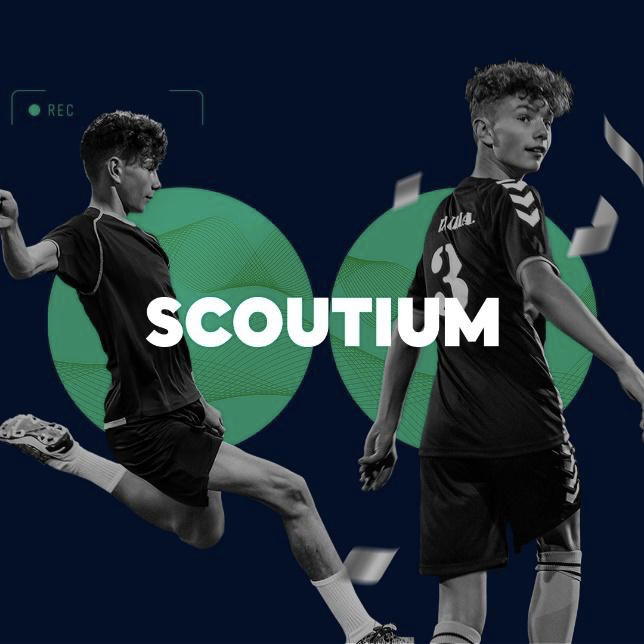

**Business problem: Scouting classification**

Predicting which class (average, highlighted) players are according to the scores given to the characteristics of the football players watched by the Scouts.

**Dataset story:**
The data set consists of information from Scoutium, which includes the features and scores of the football players evaluated by the scouts according to the characteristics of the footballers observed in the matches.

**Dataset content:**

> scoutium_attributes.csv

8 Variables 10,730 Observations 527 KB
* task_response_id: The set of a scout's evaluations of all players on a team's roster in a match
* match_id: The id of the relevant match
* evaluator_id: The id of the evaluator(scout)
* player_id: The id of the relevant player
* position_id: The id of the position played by the relevant player in that match
1. Goalkeeper
2. Stopper
3. Right-back
4. Left-back
5. Defensive midfielder
6. Central midfielder
7. Right wing
8. Left wing
9. Attacking midfielder
10. Striker
* analysis_id: Set of attribute evaluations of a scout for a player in a match
* attribute_id: The id of each attribute that the players were evaluated for
* attribute_value: The value (points) a scout gives to a player's attribute

> scoutium_potential_labels.csv
* task_response_id: The set of a scout's evaluations of all players on a team's roster in a match
* match_id: The id of the corresponding match
* evaluator_id: The id of the evaluator(scout)
* player_id: The id of the respective player
* potential_label: A label that indicates a scout's final decision regarding a player in a match. (target variable)

# Importing libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
pd.set_option('display.width', 600)     # Set display width to 600

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/scoutium/scoutium_potential_labels.csv
/kaggle/input/scoutium/scoutium_attributes.csv


**Read the scoutium_attributes.csv and scoutium_potential_labels.csv files.**

In [3]:
sc_attributes = pd.read_csv("/kaggle/input/scoutium/scoutium_attributes.csv", sep=';')
sc_potential_labels = pd.read_csv("/kaggle/input/scoutium/scoutium_potential_labels.csv", sep=';')

**Combine the csv files we have read using the merge function.("task_response_id", 'match_id', 'evaluator_id' "player_id" perform the merge operation over 4 variables.)**

In [4]:
scoutium = pd.merge(sc_attributes, sc_potential_labels, on=["task_response_id", "match_id", "evaluator_id", "player_id"])
scoutium.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [5]:
print(scoutium.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10730 entries, 0 to 10729
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
 8   potential_label   10730 non-null  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 838.3+ KB
None


**Remove the Keeper (1) class in position_id from the dataset.**

In [6]:
scoutium = scoutium[scoutium.position_id != 1]      # Remove the Keeper (1) class in position
scoutium.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [7]:
scoutium[['position_id']].value_counts()        # Check the number of players in each position

position_id
2              1972
6              1428
10             1088
8              1020
3               986
7               986
4               884
9               850
5               816
dtype: int64

**Remove the below average class in the potential label from the data set.(the below average class makes up 1% of the entire dataset)**

In [8]:
scoutium = scoutium[scoutium.potential_label != "below_average"]
scoutium.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [9]:
scoutium[['potential_label']].value_counts()    

potential_label
average            7922
highlighted        1972
dtype: int64

**Create a table from the data set you created using the "pivot_table" function. Manipulate this pivot table with one player per row.**

In [10]:
scoutium_pivot = scoutium.pivot_table(index=["task_response_id", "match_id", "evaluator_id", "player_id", "position_id","potential_label"],
                                      columns="attribute_id",
                                      values="attribute_value")
scoutium_pivot.head()

attribute_id                                                                  4322  4323  4324  4325  4326  4327  4328  4329  4330  4332  ...  4352  4353  4354  4355  4356  4357  4407  4408  4423  4426
task_response_id match_id evaluator_id player_id position_id potential_label                                                              ...                                                            
4915             62935    177676       1361061   2           average          56.0  56.0  67.0  56.0  45.0  56.0  56.0  67.0  45.0  56.0  ...  56.0  56.0  56.0  56.0  67.0  56.0  56.0  67.0  34.0  45.0
                                       1361626   10          highlighted      56.0  67.0  78.0  78.0  56.0  56.0  78.0  67.0  78.0  67.0  ...  67.0  78.0  78.0  67.0  67.0  67.0  78.0  56.0  78.0  67.0
                                       1361858   6           average          45.0  56.0  56.0  56.0  56.0  45.0  56.0  56.0  56.0  56.0  ...  56.0  45.0  56.0  56.0  56.0  56.0  56.0  56.0  45.0  56.0
                                       1362220   5           highlighted      67.0  56.0  56.0  78.0  78.0  78.0  67.0  67.0  67.0  67.0  ...  78.0  67.0  78.0  67.0  67.0  67.0  67.0  56.0  67.0  67.0
                                       1364951   9           highlighted      45.0  56.0  56.0  78.0  78.0  56.0  56.0  45.0  56.0  56.0  ...  67.0  67.0  67.0  67.0  45.0  45.0  67.0  45.0  56.0  56.0

[5 rows x 34 columns]

**Create the pivot table with “player_id”, “position_id” and “potential_label” in the index, “attribute_id” in the columns and “attribute_value” in the values given by the scouts to the players.**

In [11]:
scoutium_pivot = scoutium.pivot_table(index=["player_id", "position_id", "potential_label"],
                                      columns="attribute_id",
                                      values="attribute_value")
scoutium_pivot.head()

attribute_id                           4322  4323  4324  4325  4326  4327  4328  4329  4330  4332  ...  4352  4353  4354  4355  4356  4357  4407  4408  4423  4426
player_id position_id potential_label                                                              ...                                                            
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0  45.0  45.0  50.5  56.0  ...  56.0  34.0  39.5  50.5  34.0  34.0  56.0  34.0  34.0  56.0
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0  67.0  78.0  67.0  67.0  ...  67.0  67.0  78.0  67.0  67.0  67.0  67.0  67.0  56.0  78.0
          4           average          67.0  78.0  67.0  67.0  67.0  78.0  78.0  78.0  56.0  67.0  ...  78.0  67.0  67.0  67.0  56.0  67.0  56.0  67.0  45.0  56.0
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0  67.0  67.0  89.0  78.0  ...  67.0  56.0  67.0  67.0  56.0  67.0  89.0  56.0  67.0  78.0

[5 rows x 34 columns]

**Assign the indexes as variables using the "reset_index" function and convert the names of the "attribute_id" columns to strings.**

In [12]:
scoutium_pivot = scoutium_pivot.reset_index()       # Assign the indexes as variables
scoutium_pivot.columns = scoutium_pivot.columns.astype(str)     # Convert the names of the "attribute_id" columns to strings.
scoutium_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


**Express the “potential_label” categories (average, highlighted) numerically using the Label Encoder function.**

In [13]:
le = LabelEncoder()     # Label Encoder
scoutium_pivot["potential_label"] = le.fit_transform(scoutium_pivot["potential_label"])
scoutium_pivot.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


**Assign the numeric variable columns to a list with the name “num_cols”.**

In [20]:
num_cols = [col for col in scoutium_pivot.columns if col not in ["player_id", "position_id", "potential_label"]]
scoutium_pivot_num = scoutium_pivot[num_cols]

**Apply StandardScaler to scale the data in all the "num_cols" variables you have saved.**

In [22]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data in num_cols
scaler.fit(scoutium_pivot[num_cols])

# Transform the data in num_cols
scoutium_pivot[num_cols] = scaler.transform(scoutium_pivot[num_cols])

scoutium_pivot[num_cols].head()

attribute_id,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,-0.791605,-0.446324,-0.122619,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,0.404075,0.727985,0.691171,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,1.001915,0.727985,0.691171,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,1.001915,-0.054888,0.691171,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,0.404075,2.293730,1.504961,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


**Develop a machine learning model that predicts the potential tags of football players with minimum error from the data set we have. (Print the roc_auc, f1, precision, recall, accuracy metrics.)**

In [23]:
X = scoutium_pivot.drop(["potential_label", "player_id"], axis=1)
y = scoutium_pivot["potential_label"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def base_models(X, y, scoring):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

scores = ["roc_auc", "f1", "precision", "recall", "accuracy"]

for i in scores:
    base_models(X, y, i)

Base Models....
roc_auc: 0.8177 (LR) 
roc_auc: 0.6914 (KNN) 
roc_auc: 0.8396 (SVC) 
roc_auc: 0.7248 (CART) 
roc_auc: 0.8913 (RF) 
roc_auc: 0.7781 (Adaboost) 
roc_auc: 0.8562 (GBM) 
roc_auc: 0.8441 (XGBoost) 
roc_auc: 0.8588 (LightGBM) 
roc_auc: 0.8924 (CatBoost) 
Base Models....
f1: 0.537 (LR) 
f1: 0.3457 (KNN) 
f1: 0.0351 (SVC) 
f1: 0.5329 (CART) 
f1: 0.5607 (RF) 
f1: 0.5668 (Adaboost) 
f1: 0.597 (GBM) 
f1: 0.6037 (XGBoost) 
f1: 0.5788 (LightGBM) 
f1: 0.6066 (CatBoost) 
Base Models....
precision: 0.7331 (LR) 
precision: 0.9444 (KNN) 
precision: 0.3333 (SVC) 
precision: 0.5551 (CART) 
precision: 0.8796 (RF) 
precision: 0.6335 (Adaboost) 
precision: 0.7151 (GBM) 
precision: 0.6904 (XGBoost) 
precision: 0.6599 (LightGBM) 
precision: 0.8524 (CatBoost) 
Base Models....
recall: 0.4454 (LR) 
recall: 0.2154 (KNN) 
recall: 0.0185 (SVC) 
recall: 0.5185 (CART) 
recall: 0.4279 (RF) 
recall: 0.5341 (Adaboost) 
recall: 0.5175 (GBM) 
recall: 0.5526 (XGBoost) 
recall: 0.5175 (LightGBM) 
recall: 0.480

**Draw the order of the features using the feature_importance function, which indicates the importance of the variables.**

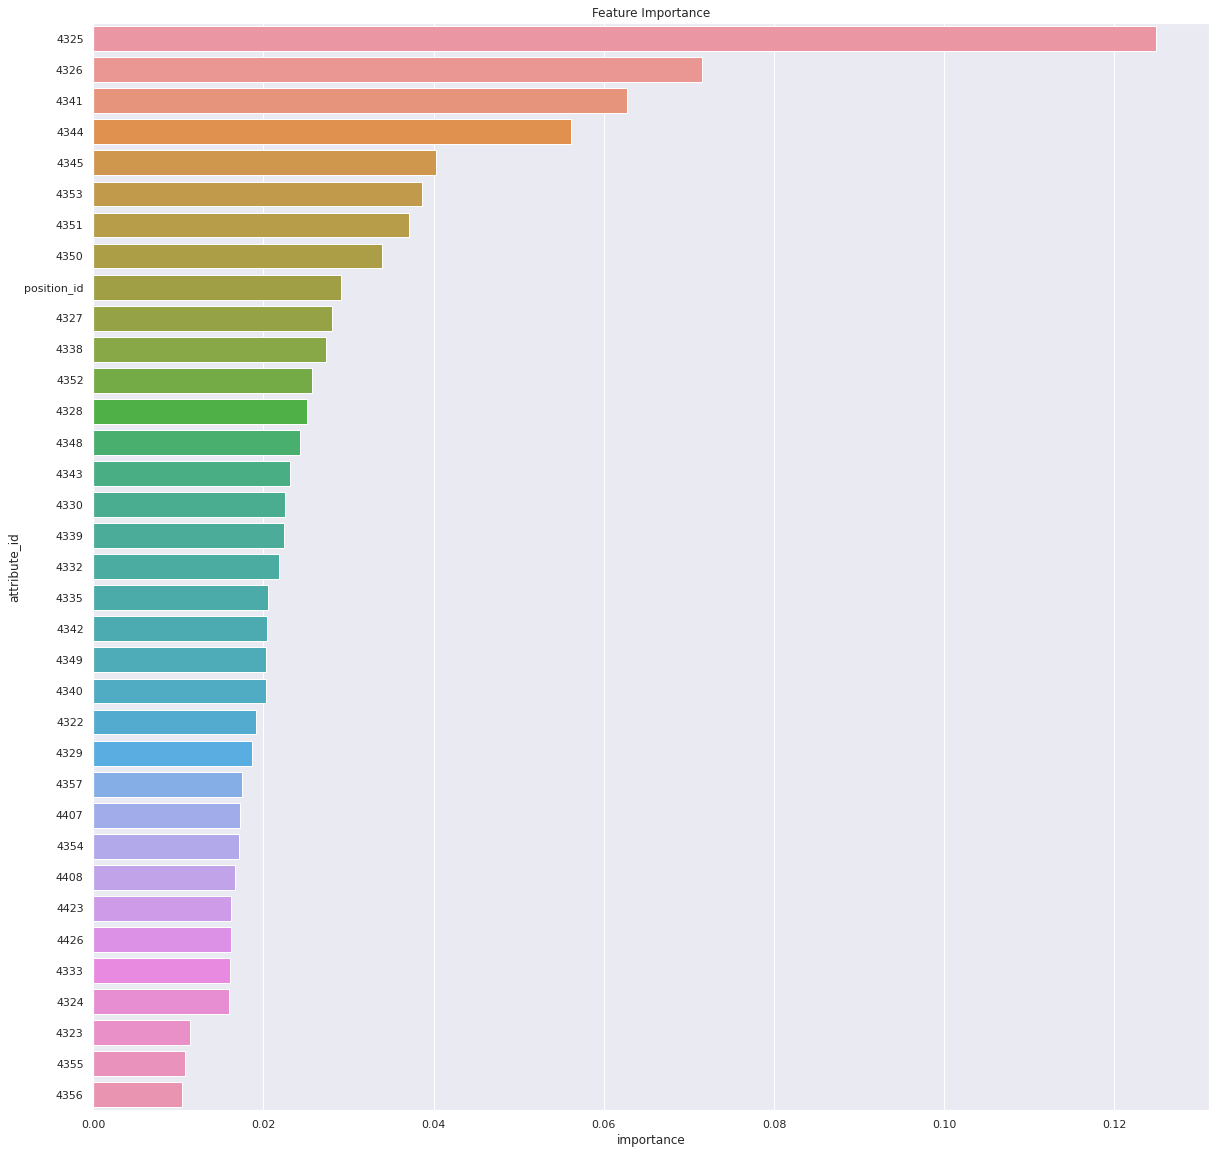

In [40]:
def feature_importance(model, X_train, y_train):
    model.fit(X_train, y_train)
    feature_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["importance"])
    feature_importance.sort_values(by="importance", ascending=False, inplace=True)
    plt.figure(figsize=(20, 20))
    sns.barplot(x=feature_importance.importance, y=feature_importance.index)
    plt.title("Feature Importance")
    plt.show()

feature_importance(RandomForestClassifier(), X_train, y_train)